In [1]:
import  tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataset import Graph_Classification_Dataset,Inference_Dataset
from sklearn.metrics import r2_score,roc_auc_score

import os
from model import  PredictModel_test,BertModel_test


In [2]:
medium = {'name':'Medium','num_layers': 6, 'num_heads': 8, 'd_model': 256,'path':'medium_weights','addH':True}

In [109]:
arch = medium  ## small 3 4 128   medium: 6 6  256     large:  12 8 516
trained_epoch = 8
num_layers = arch['num_layers']
num_heads = arch['num_heads']
d_model = arch['d_model']
addH = arch['addH']

dff = d_model * 2
vocab_size = 17
dropout_rate = 0.1

seed = 7
np.random.seed(seed=seed)
tf.random.set_seed(seed=seed)

task = 'logD'
df = pd.read_csv('data/reg/logD.txt',sep='\t')
sml_list = df['SMILES'].tolist()
inference_dataset = Inference_Dataset(['C=C(CC)C(=O)c1ccc(OCC(=O)[O-])c(Cl)c1Cl',
                                        'CN(Cc1c(C(=O)NC2CCCC(O)C2)noc1-c1ccc(C(F)(F)F)cc1)C1CCOC1',
                                        'CC(=O)Nc1ccc(O)cc1',
                                       'CC(=O)CC(c1ccc([N+](=O)[O-])cc1)c1c(O)c2ccccc2oc1=O',
                                       'Cc1cccc(NC(=S)Oc2ccc3ccccc3c2)c1',
                                       'CC(=O)Nc1nnc(S(N)(=O)=O)s1',
                                       'CC(=O)c1ccc(S(=O)(=O)NC(=O)NC2CCCCC2)cc1',
                                       'N#Cc1c(Cl)c2ccccc2n2c1nc1ccccc12',
                                       'CN(C(=O)C(Cc1ccccc1Cl)C[NH+]1CCC2(CC1)OCCc1cc(F)sc12)C1CC1'],addH=addH).get_data()

In [110]:
x, adjoin_matrix, smiles ,atom_list = next(iter(inference_dataset.take(1)))
seq = tf.cast(tf.math.equal(x, 0), tf.float32)

mask = seq[:, tf.newaxis, tf.newaxis, :]
model = PredictModel_test(num_layers=num_layers, d_model=d_model, dff=dff, num_heads=num_heads, vocab_size=vocab_size,
                     dense_dropout=0.15)
pred = model(x,mask=mask,training=True,adjoin_matrix=adjoin_matrix)
model.load_weights('regression_weights/logD.h5')

In [111]:
x, adjoin_matrix, smiles ,atom_list = next(iter(inference_dataset.take(1)))
seq = tf.cast(tf.math.equal(x, 0), tf.float32)
mask = seq[:, tf.newaxis, tf.newaxis, :]
x,atts,xs= model(x,mask=mask,training=True,adjoin_matrix=adjoin_matrix)

In [112]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import SVG,display
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.Draw.MolDrawing import DrawingOptions

In [113]:

def plot_weights(smiles,attention_plot,max=5):
    mol = Chem.MolFromSmiles(smiles_plot)
    mol = Chem.RemoveHs(mol)
#     mol = Chem.AddHs(mol)
    num_atoms = mol.GetNumAtoms()
    atoms = []

    for i in range(num_atoms):
        atom = mol.GetAtomWithIdx(i)
        atoms.append(atom.GetSymbol()+str(i))


#   att = tf.reduce_mean(tf.reduce_mean(attentions_plot[:,:,0,:],axis=0),axis=0)[1:].numpy()
    att = tf.reduce_mean(tf.reduce_mean(attentions_plot[3:,:,0,:],axis=0),axis=0)[1:].numpy()  #num_layers * num_heads * num_atoms * num_atoms
    print(attentions_plot[:,:,0,0].numpy())
    indices = (-att).argsort()
    highlight = indices.tolist()
    print([[atoms[indices[i]],('%.2f'%att[indices[i]])] for i in range(len(indices))])


    drawer = rdMolDraw2D.MolDraw2DSVG(800,600)
    opts = drawer.drawOptions()
    drawer.drawOptions().updateAtomPalette({k: (0, 0, 0) for k in DrawingOptions.elemDict.keys()})


#     for i in range(mol.GetNumAtoms()):
#         opts.atomLabels[i] = mol.GetAtomWithIdx(i).GetSymbol()
    
    colors = {}
    for i,h in enumerate(highlight):
        colors[h] = (1,
                     1-1*(att[h]-att[highlight[-1]])/(att[highlight[0]]-att[highlight[-1]]),
                     1-1*(att[h]-att[highlight[-1]])/(att[highlight[0]]-att[highlight[-1]]))
    drawer.DrawMolecule(mol,highlightAtoms = highlight,highlightAtomColors=colors,highlightBonds=[])
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText().replace('svg:','')
    display(SVG(svg))

tf.Tensor(
[[-0.15193701]
 [ 0.0857678 ]
 [-0.09855729]
 [ 0.03653456]
 [ 0.23049754]
 [-0.18139991]
 [-0.07223756]
 [ 0.12509255]
 [ 0.09844822]], shape=(9, 1), dtype=float32)
[[1.5023704e-02 3.0344253e-02 4.5494419e-02 4.8004821e-02 3.4156151e-02
  1.4404777e-02 1.0964113e-03 2.3499159e-02]
 [1.0381888e-02 3.6950138e-01 6.4612960e-04 1.5233940e-04 3.5452363e-01
  3.7414333e-01 2.2833589e-03 9.2448238e-03]
 [1.5723807e-01 9.6246377e-02 5.1749420e-01 1.5375662e-03 2.5299711e-02
  1.8586704e-03 4.3790180e-02 1.0900794e-02]
 [1.1573279e-01 2.0645808e-01 5.1126617e-04 3.3645552e-05 3.8181900e-03
  2.8996819e-01 3.5365025e-05 1.0235108e-01]
 [6.0060169e-03 8.8664657e-04 3.4091028e-03 2.1245851e-05 5.0154366e-03
  2.6081174e-03 1.1903855e-01 1.2522010e-03]
 [2.9493930e-02 7.1449135e-03 2.0333484e-02 4.1452795e-03 7.5381919e-04
  2.0864657e-04 3.7369370e-02 3.9383145e-03]]
[['C12', '0.09'], ['C4', '0.05'], ['C1', '0.05'], ['Cl16', '0.05'], ['O13', '0.05'], ['C11', '0.05'], ['Cl18', '0.04'], 

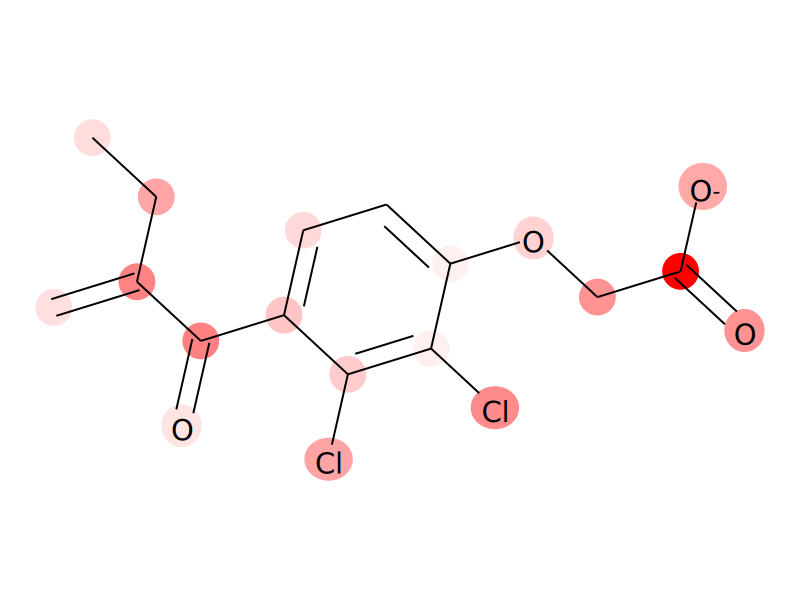

In [114]:
i = 0
print(x)
smiles_plot = smiles[i].numpy().tolist()[0].decode()
mol = Chem.MolFromSmiles(smiles_plot)
num_atoms = mol.GetNumAtoms()
attentions_plot = tf.concat([att[i:(i+1),:,:num_atoms+1,:num_atoms+1] for att in atts],axis=0)
plot_weights(smiles_plot,attentions_plot)

[[6.89482968e-03 1.48994159e-02 7.52796605e-03 2.89455391e-02
  1.54171456e-02 7.28042470e-03 5.36869222e-04 7.30144233e-03]
 [6.40024804e-03 2.56483793e-01 1.24529933e-08 5.89834381e-05
  2.32830837e-01 2.04206094e-01 7.13850663e-04 4.99375537e-03]
 [1.65568531e-01 9.13737640e-02 1.67357817e-01 4.17248858e-03
  1.61604621e-02 3.11652012e-03 2.07260139e-02 1.70318864e-03]
 [9.28842425e-02 1.76023737e-01 1.24262689e-04 6.29518399e-06
  5.49880788e-02 5.24719000e-01 6.12801814e-05 1.32069379e-01]
 [1.74292037e-03 2.31662905e-03 1.29874062e-03 1.17073439e-04
  7.80323520e-04 5.66257723e-03 1.22577704e-01 7.06086168e-03]
 [8.98208469e-03 9.57622379e-02 1.84894614e-02 3.38323577e-03
  1.20570429e-03 7.59749906e-04 1.46329496e-02 1.41691032e-03]]
[['C28', '0.04'], ['N15', '0.03'], ['N7', '0.03'], ['C21', '0.03'], ['C3', '0.03'], ['C19', '0.03'], ['F23', '0.02'], ['O16', '0.02'], ['C18', '0.02'], ['C27', '0.02'], ['C4', '0.02'], ['C17', '0.02'], ['F25', '0.02'], ['C10', '0.02'], ['C8', '0.02'

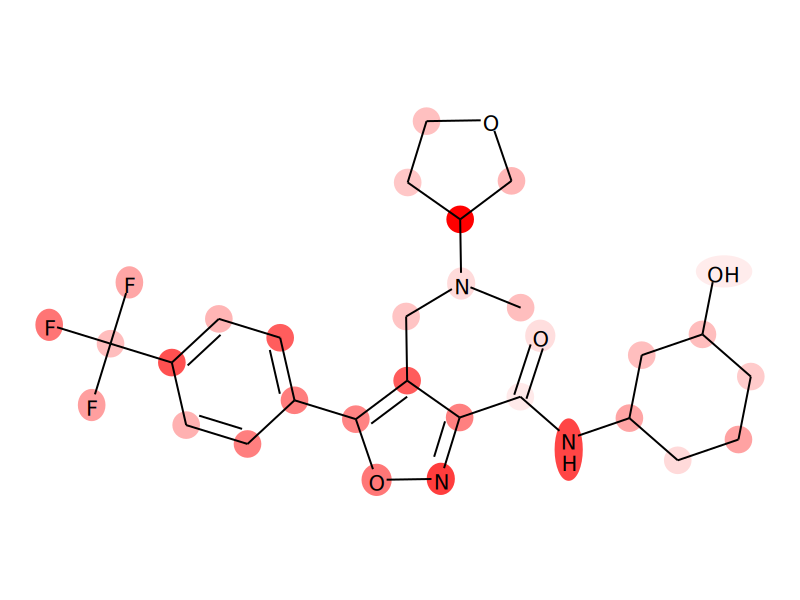

In [115]:
i = 1
smiles_plot = smiles[i].numpy().tolist()[0].decode()
mol = Chem.MolFromSmiles(smiles_plot)
num_atoms = mol.GetNumAtoms()
attentions_plot = tf.concat([att[i:(i+1),:,:num_atoms+1,:num_atoms+1] for att in atts],axis=0)
plot_weights(smiles_plot,attentions_plot)

[[2.0097841e-02 3.8005736e-02 1.7162796e-02 9.4156295e-02 4.4577800e-02
  2.5198737e-02 1.7308237e-03 3.0619234e-02]
 [1.8334223e-02 6.1077613e-01 3.2695130e-08 3.6280128e-04 5.2104694e-01
  3.4166935e-01 1.2632470e-03 2.5051709e-02]
 [2.5296918e-01 1.6486625e-01 5.5086643e-01 1.0394200e-02 3.9144859e-02
  5.5296267e-03 2.0227471e-01 2.0934496e-02]
 [5.1406920e-01 2.6727670e-01 3.0593004e-04 4.1021476e-04 2.0051003e-01
  6.9965893e-01 2.6527767e-05 3.6291230e-01]
 [4.4825189e-03 1.0942755e-02 1.7147402e-04 2.0159196e-04 3.3072211e-02
  4.4200830e-02 5.0203115e-01 3.0181992e-03]
 [2.8576599e-03 8.6777620e-02 2.6833426e-02 3.9117937e-03 1.3815513e-03
  8.5254334e-04 1.9306324e-01 1.5353090e-03]]
[['C1', '0.06'], ['N3', '0.05'], ['O8', '0.04'], ['O2', '0.04'], ['C0', '0.04'], ['C9', '0.03'], ['C10', '0.03'], ['C7', '0.03'], ['C5', '0.03'], ['C6', '0.03'], ['C4', '0.03']]


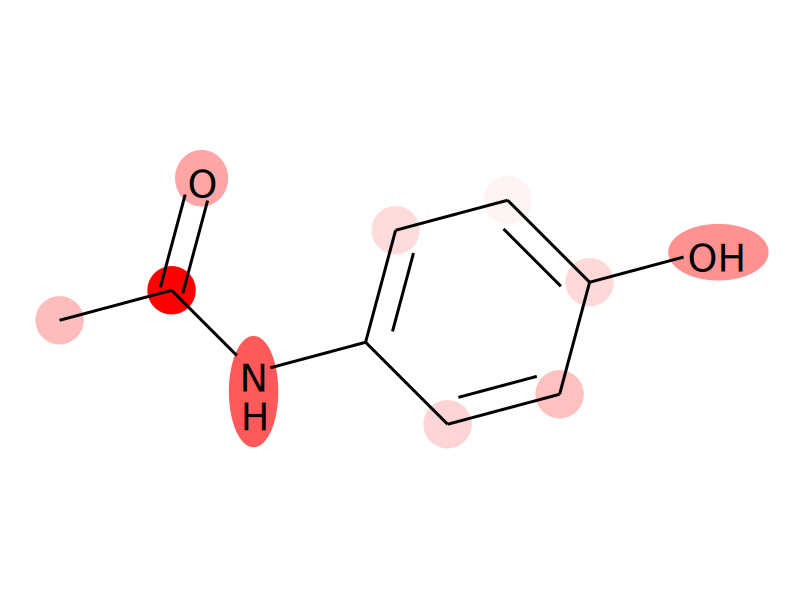

In [116]:
i = 2
smiles_plot = smiles[i].numpy().tolist()[0].decode()
mol = Chem.MolFromSmiles(smiles_plot)
num_atoms = mol.GetNumAtoms()
attentions_plot = tf.concat([att[i:(i+1),:,:num_atoms+1,:num_atoms+1] for att in atts],axis=0)
plot_weights(smiles_plot,attentions_plot)

[[1.2018771e-02 2.2423157e-02 1.3191804e-02 4.1383844e-02 2.3521027e-02
  1.0851206e-02 6.5603404e-04 1.5982086e-02]
 [9.5491046e-03 3.3138108e-01 5.8257076e-05 4.4173892e-05 2.9230884e-01
  2.9452130e-01 1.1781246e-03 6.7918748e-03]
 [1.1707713e-01 6.3146323e-02 2.7184546e-01 3.1322534e-03 9.5321732e-03
  9.4177504e-04 8.8862196e-02 1.4179425e-02]
 [6.8174109e-02 1.3914627e-01 1.3322181e-04 1.6393271e-05 2.1870697e-03
  5.3051454e-01 3.8760525e-05 1.2014685e-01]
 [8.6084136e-04 2.0561074e-03 5.0923224e-03 6.3965839e-05 2.1022356e-03
  7.6416042e-03 4.4321410e-02 9.6338068e-04]
 [2.9517002e-02 8.7936997e-02 1.1874230e-02 6.9303187e-03 2.4475150e-03
  3.9155904e-04 2.3470078e-02 9.4281638e-04]]
[['C24', '0.06'], ['C14', '0.05'], ['O11', '0.03'], ['C4', '0.03'], ['C5', '0.03'], ['C1', '0.03'], ['C8', '0.03'], ['C15', '0.03'], ['O10', '0.03'], ['O2', '0.03'], ['C12', '0.03'], ['C6', '0.03'], ['N9', '0.03'], ['C7', '0.02'], ['C13', '0.02'], ['C22', '0.02'], ['C19', '0.02'], ['O25', '0.02']

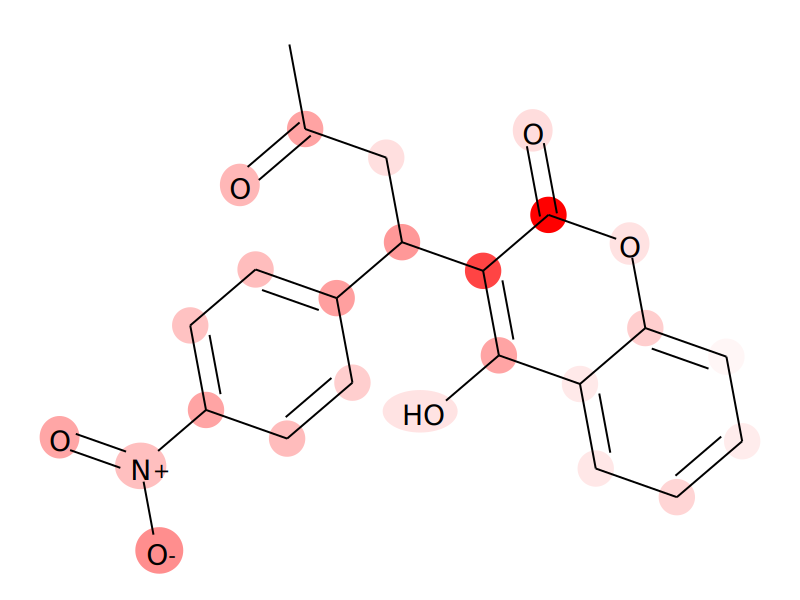

In [117]:
i = 3
smiles_plot = smiles[i].numpy().tolist()[0].decode()
mol = Chem.MolFromSmiles(smiles_plot)
num_atoms = mol.GetNumAtoms()
attentions_plot = tf.concat([att[i:(i+1),:,:num_atoms+1,:num_atoms+1] for att in atts],axis=0)
plot_weights(smiles_plot,attentions_plot)

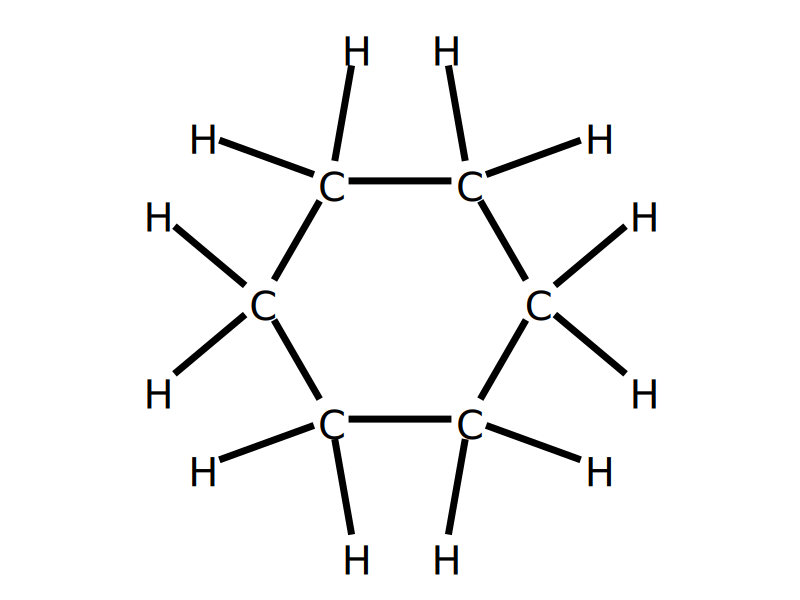

In [12]:
drawer = rdMolDraw2D.MolDraw2DSVG(800,600)
drawer.SetLineWidth(4)
opts = drawer.drawOptions()
mol = Chem.MolFromSmiles( 'C1CCCCC1')
mol = Chem.AddHs(mol)

for i in range(mol.GetNumAtoms()):
    opts.atomLabels[i] = mol.GetAtomWithIdx(i).GetSymbol()
drawer.DrawMolecule(mol)
drawer.FinishDrawing()
svg = drawer.GetDrawingText().replace('svg:','')
display(SVG(svg))
##2

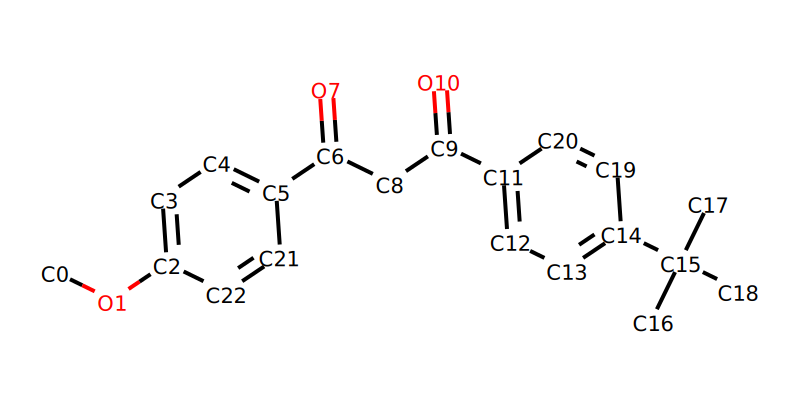

In [13]:
drawer = rdMolDraw2D.MolDraw2DSVG(800,400)
opts = drawer.drawOptions()
drawer.SetLineWidth(5)
mol = Chem.MolFromSmiles('COc1ccc(C(=O)CC(=O)c2ccc(C(C)(C)C)cc2)cc1')
for i in range(mol.GetNumAtoms()):
    opts.atomLabels[i] = mol.GetAtomWithIdx(i).GetSymbol()+str(i)

drawer.DrawMolecule(mol)
drawer.FinishDrawing()
svg = drawer.GetDrawingText().replace('svg:','')
display(SVG(svg))
##1

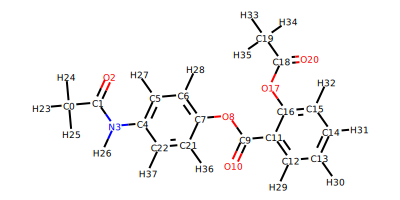

In [36]:
drawer = rdMolDraw2D.MolDraw2DSVG(400,200)
opts = drawer.drawOptions()
mol = Chem.MolFromSmiles( 'CC(=O)Nc1ccc(OC(=O)c2ccccc2OC(C)=O)cc1')
mol = Chem.AddHs(mol)
for i in range(mol.GetNumAtoms()):
    opts.atomLabels[i] = mol.GetAtomWithIdx(i).GetSymbol()+str(i)

drawer.DrawMolecule(mol)
drawer.FinishDrawing()
svg = drawer.GetDrawingText().replace('svg:','')
display(SVG(svg))

##5

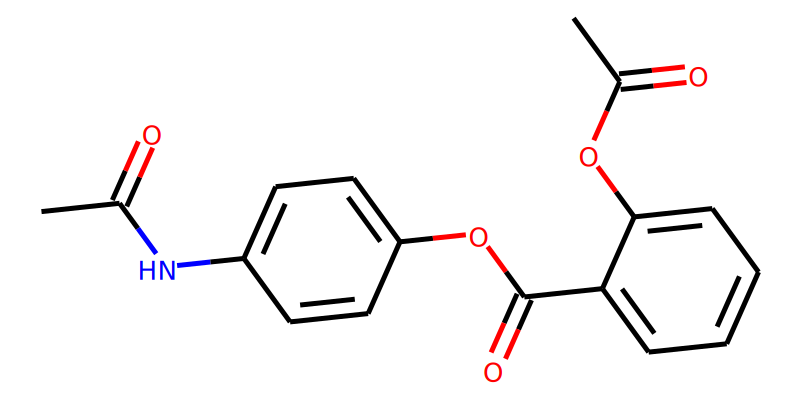

In [9]:
drawer = rdMolDraw2D.MolDraw2DSVG(800,400)
drawer.SetLineWidth(5)
opts = drawer.drawOptions()
mol = Chem.MolFromSmiles( 'CC(=O)Nc1ccc(OC(=O)c2ccccc2OC(C)=O)cc1')
# # drawer.drawOptions().updateAtomPalette({k: (0, 0, 0) for k in DrawingOptions.elemDict.keys()})
# for i in range(mol.GetNumAtoms()):
#     opts.atomLabels[i] = mol.GetAtomWithIdx(i).GetSymbol()     #+str(i)

drawer.DrawMolecule(mol)
drawer.FinishDrawing()
svg = drawer.GetDrawingText().replace('svg:','')
display(SVG(svg))

##6

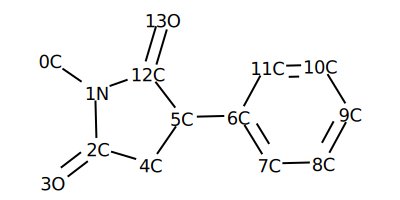

In [6]:
drawer = rdMolDraw2D.MolDraw2DSVG(400,200)
opts = drawer.drawOptions()
drawer.drawOptions().updateAtomPalette({k: (0, 0, 0) for k in DrawingOptions.elemDict.keys()})
mol = Chem.MolFromSmiles('CN1C(=O)CC(c2ccccc2)C1=O')
for i in range(mol.GetNumAtoms()):
    opts.atomLabels[i] = str(i) + mol.GetAtomWithIdx(i).GetSymbol()

drawer.DrawMolecule(mol)
drawer.FinishDrawing()
svg = drawer.GetDrawingText().replace('svg:','')
display(SVG(svg))

##3

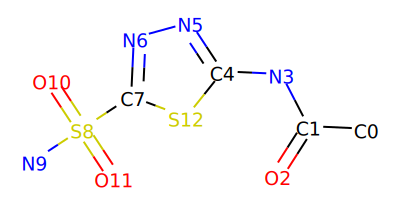

In [12]:
drawer = rdMolDraw2D.MolDraw2DSVG(400,200)
opts = drawer.drawOptions()
mol = Chem.MolFromSmiles('CC(=O)Nc1nnc(S(N)(=O)=O)s1')
for i in range(mol.GetNumAtoms()):
    opts.atomLabels[i] = mol.GetAtomWithIdx(i).GetSymbol()+str(i)

drawer.DrawMolecule(mol)
drawer.FinishDrawing()
svg = drawer.GetDrawingText().replace('svg:','')
display(SVG(svg))

##4